In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import pickle



pd.set_option("display.max_columns",200)

def print_value_counts(df):
    for i in df.columns:
        print(f'column: {i}')
        display(df[i].value_counts())
        print()

Steps:

1. Select relevant cols
2. Impute NA - strategies: categorical - mode and NA, numeric median (or sth else)
3. one-hot encode categorical
4. merge categorical and numeric 
5. Fit models

Contents:

- load data
- train test split
- preprocess categorical vars
- preprocess numeric vars
- run CV

## Load data

In [3]:
master_table = pd.read_pickle('data/master_table.pkl')

In [4]:
master_table.shape

(1876005, 36)

In [5]:
master_table.head()

,accident_id,lighting,localization,intersection_type,weather,collision_type,com,address,gps,lat,long,departament,time,year,month,hour,road_category,road_regime,no_lanes,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,user_id,place_in_car,user_type,injury_type,sex,equipment_used,pedestrian_action,pedestrian_alone,year_of_birth,vechicle_number,y
0,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678507,1,Driver,Light injury,Male,yes,not specified or not applicable,NaN,1976,A01,0
1,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678508,1,Driver,Hospitalized wounded,Female,yes,not specified or not applicable,NaN,1968,B02,1
2,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678509,2,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,1964,B02,0
3,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678510,4,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,2004,B02,0
4,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678511,5,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,1998,B02,0


## EDA with filtering approach and feature selection

In [6]:
master_table['year_of_birth'] = master_table['year_of_birth'].astype(float)

In [7]:
cols_to_model = [
#  'accident_id',
 'lighting',
 'localization',
 'intersection_type',
 'weather',
 'collision_type',
#  'com',
#  'address',
#  'gps',
#  'lat',
#  'long',
#  'departament',
#  'time',
 'year',
 'month',
 'hour',
 'road_category',
 'road_regime',
 'no_lanes',
 'reserved_lane',
 'road_gradient',
 'road_plan',
 'road_condition',
 'infrastructure',
 'accident_situation',
#  'user_id',
 'place_in_car',
 'user_type',
#  'injury_type',
 'sex',
 'equipment_used',
 'pedestrian_action',
 'pedestrian_alone',
 'year_of_birth',
#  'vechicle_number',
#  'y'
]


In [8]:
df = master_table[['y'] + cols_to_model]

In [9]:
df.dtypes

y                       int64
lighting               object
localization           object
intersection_type      object
weather                object
collision_type         object
year                  float64
month                 float64
hour                  float64
road_category          object
road_regime            object
no_lanes              float64
reserved_lane          object
road_gradient          object
road_plan              object
road_condition         object
infrastructure         object
accident_situation     object
place_in_car           object
user_type              object
sex                    object
equipment_used         object
pedestrian_action      object
pedestrian_alone       object
year_of_birth         float64
dtype: object

In [10]:
data_to_plot = df[['y', 'sex']].groupby(['y', 'sex']).size().reset_index(name='count')

In [11]:
df[['y', 'sex']].groupby(['y', 'sex']).size().reset_index(name='count')

,y,sex,count
0,0,Female,479125
1,0,Male,952622
2,1,Female,137864
3,1,Male,306394


In [14]:
plt.rcParams['figure.figsize'] = [10, 4]
cat_col = list(df.select_dtypes('object').columns)

In [15]:
si = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'NA', add_indicator=False)
temp = si.fit_transform(df[cat_col])
df_cat2 = pd.DataFrame(temp, columns = cat_col)
df_cat2.head()

,lighting,localization,intersection_type,weather,collision_type,road_category,road_regime,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,place_in_car,user_type,sex,equipment_used,pedestrian_action,pedestrian_alone
0,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Male,yes,not specified or not applicable,NA
1,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Female,yes,not specified or not applicable,NA
2,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,2,Passenger,Male,yes,not specified or not applicable,NA
3,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,4,Passenger,Male,yes,not specified or not applicable,NA
4,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,5,Passenger,Male,yes,not specified or not applicable,NA


In [17]:
df['user_age'] = df['year'] - df['year_of_birth']
df_num = df.select_dtypes('number')

<ipython-input-17-9dc64a34531f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_age'] = df['year'] - df['year_of_birth']


In [18]:
df_cat2 = pd.concat([df_cat2, df_num], axis=1)

In [35]:
cols

['lighting',
 'localization',
 'intersection_type',
 'weather',
 'collision_type',
 'road_category',
 'road_regime',
 'reserved_lane',
 'road_gradient',
 'road_plan',
 'road_condition',
 'infrastructure',
 'accident_situation',
 'place_in_car',
 'user_type',
 'sex',
 'equipment_used',
 'pedestrian_action',
 'pedestrian_alone',
 'year',
 'month',
 'hour',
 'no_lanes',
 'year_of_birth',
 'user_age']

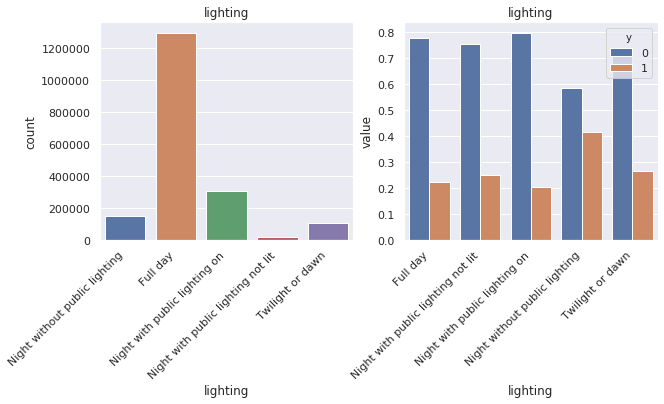

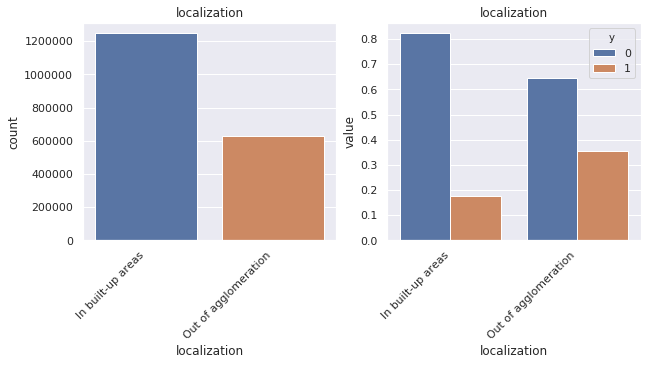

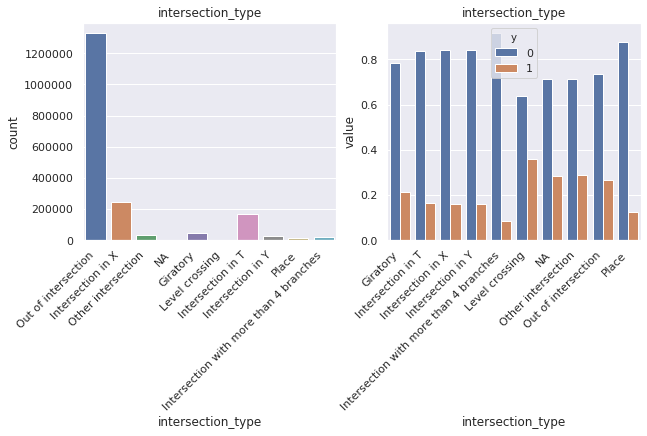

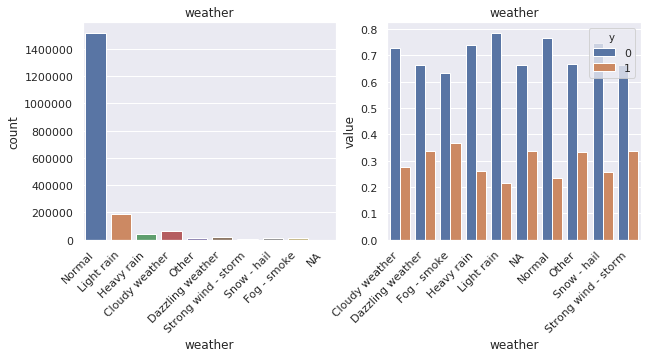

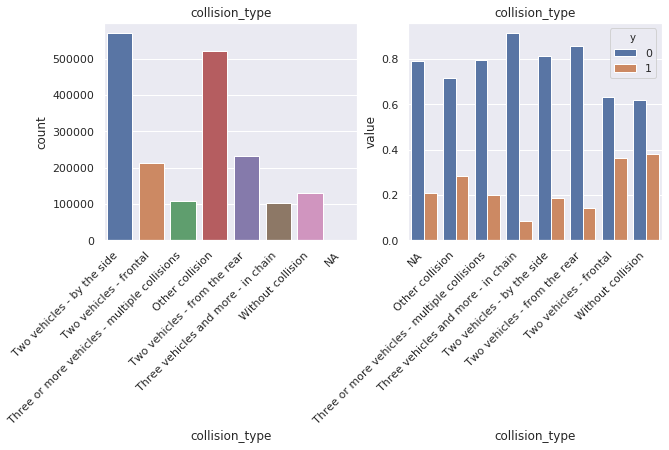

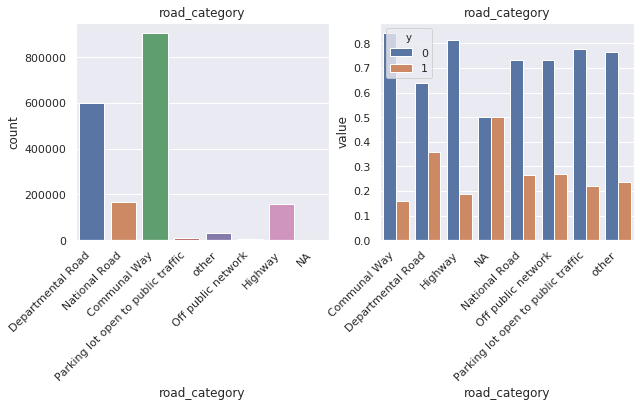

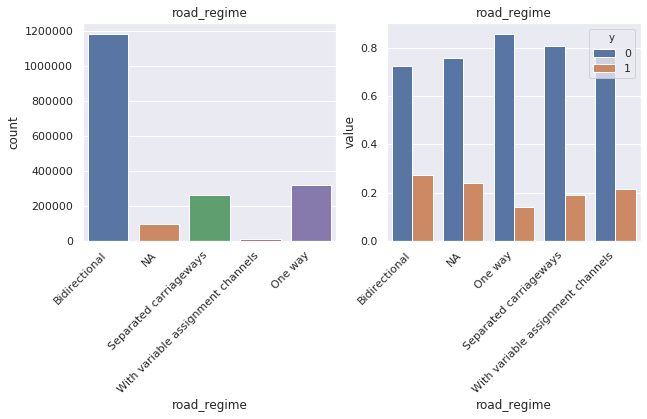

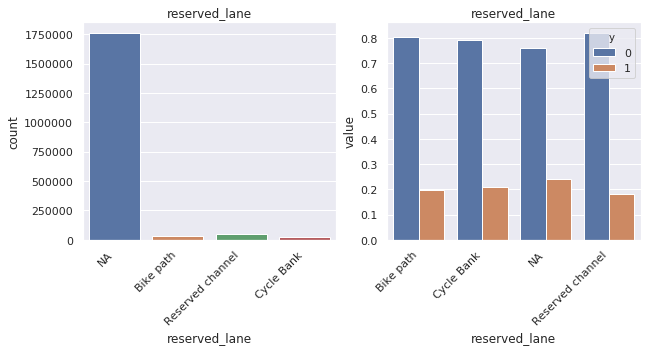

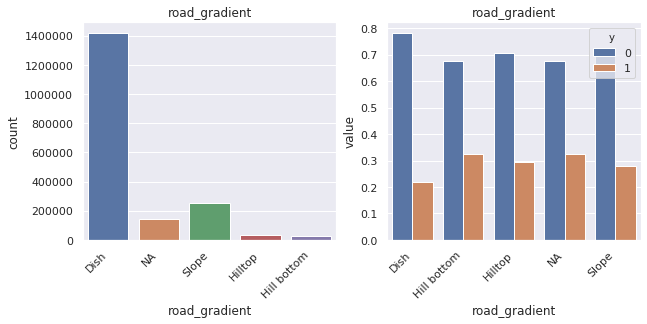

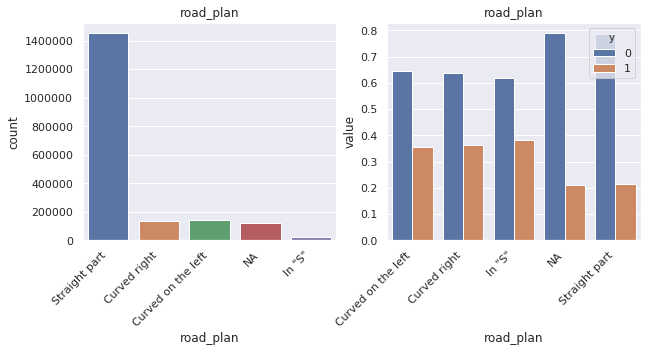

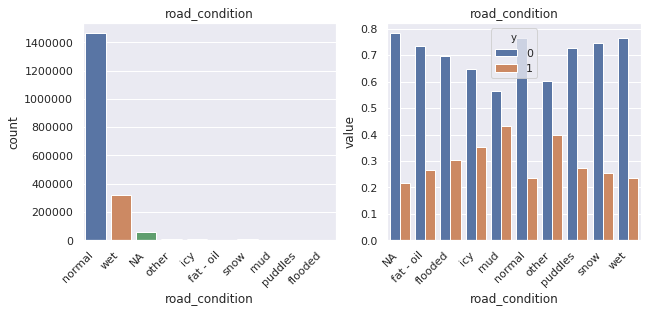

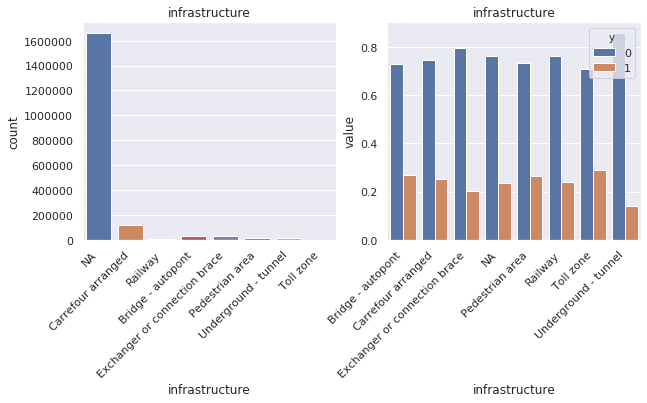

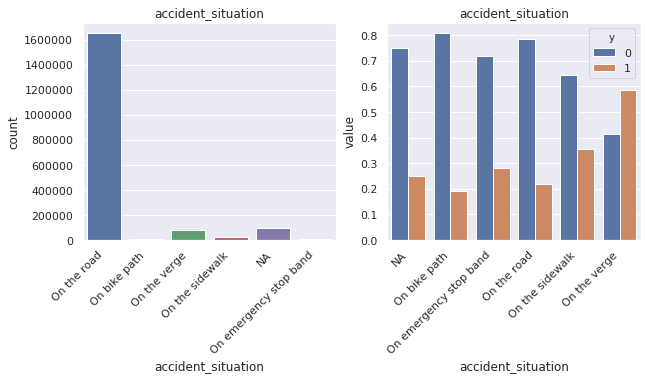

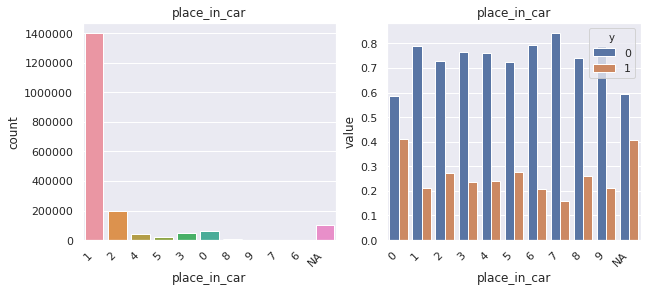

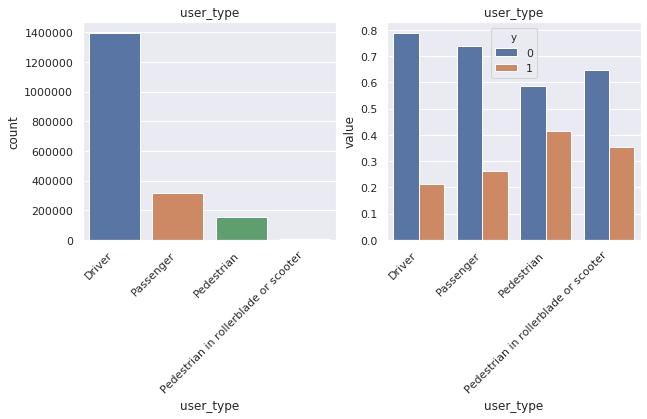

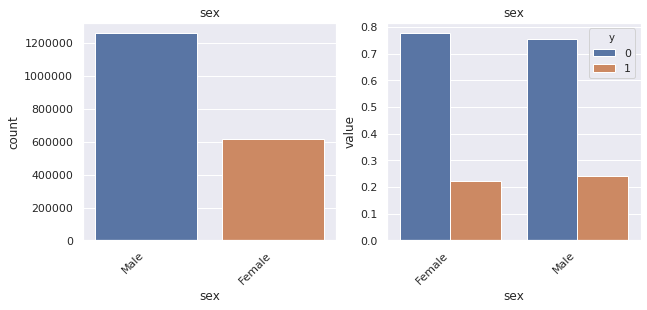

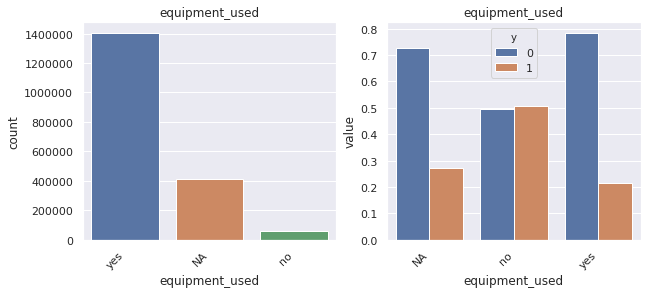

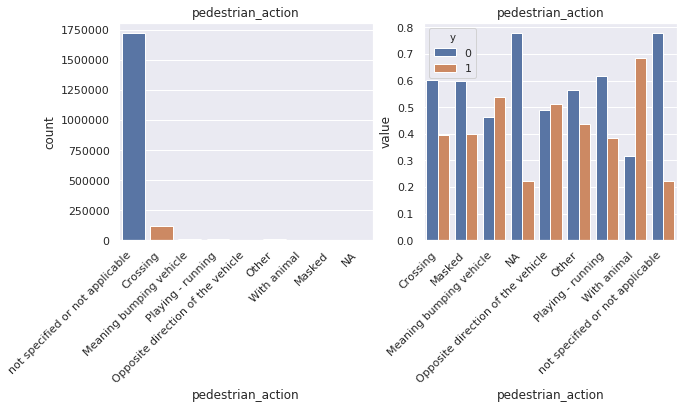

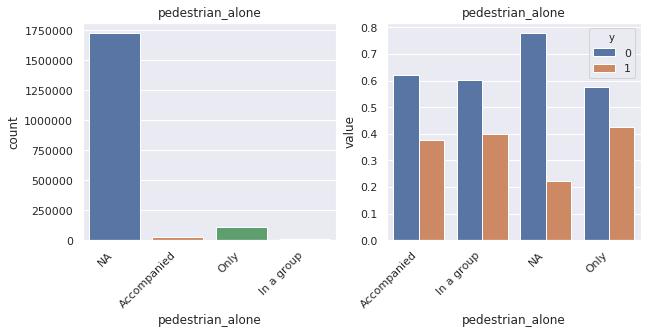

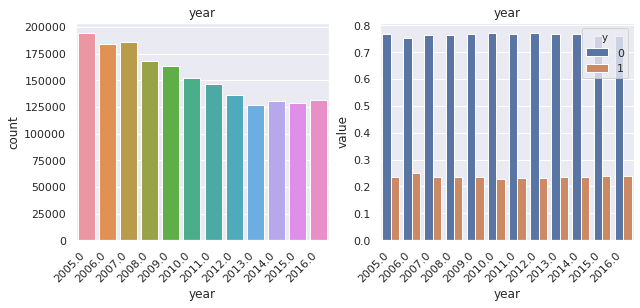

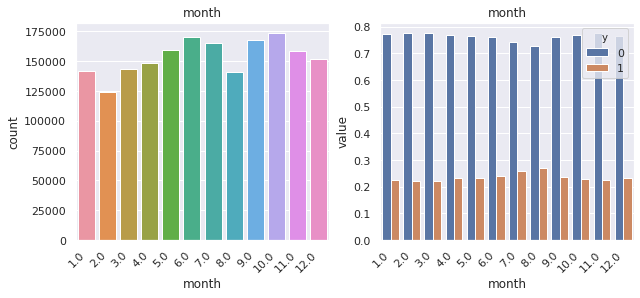

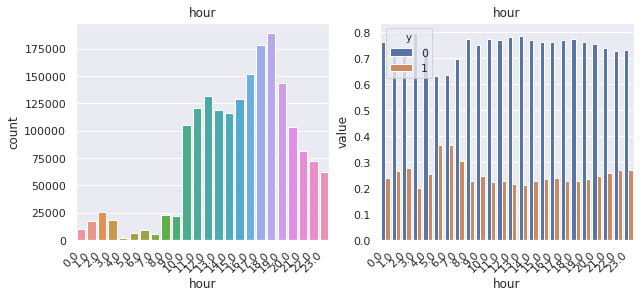

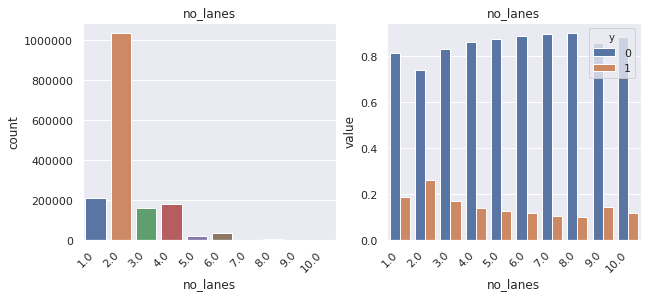

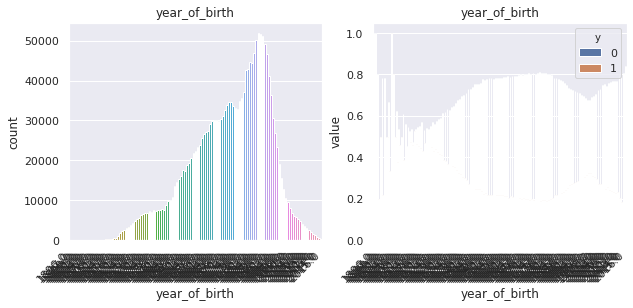

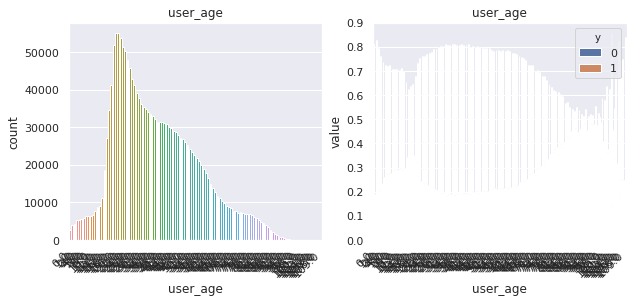

In [19]:
cols = list(df_cat2.columns)
cols.remove('y')
for col in cols:

    sns.set()
    a = pd.crosstab(df_cat2[col], columns=df_cat2['y'], 
                     normalize='index').reset_index()
    b = pd.melt(a, id_vars=[col], value_vars=[0, 1])
    plt.figure()
    plt.subplot(1, 2, 1)
    
    bar = sns.countplot(x=col, data=df_cat2)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    bar.set_title(col)
    
    plt.subplot(1, 2, 2)
#     plt.figure()
    bar = sns.barplot(x=col, y="value", hue="y", data=b)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    bar.set_title(col)
    plt.show()

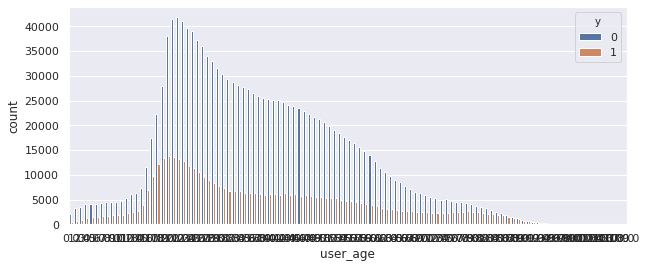

In [20]:
sns.countplot('user_age', hue = 'y', data = df_cat2)

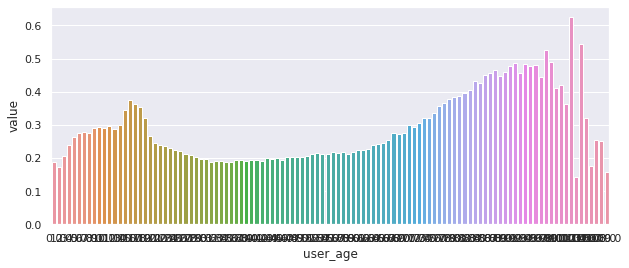

In [34]:
a = pd.crosstab(df_cat2['user_age'], columns=df_cat2['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['user_age'], value_vars=[0, 1])

b

sns.barplot(x = 'user_age', y = 'value', data = b.query('y==1'))

What to do next:

- Assess each variable's usability
- Set up LR and for each usable variable (by naked eye) try to find correct division

In [62]:
plt.rcParams['figure.figsize'] = [10, 2]
def do_plot(col, df_cat2 = df_cat2):

    sns.set()
    a = pd.crosstab(df_cat2[col], columns=df_cat2['y'], 
                     normalize='index').reset_index()
    b = pd.melt(a, id_vars=[col], value_vars=[0, 1])
    plt.figure()
    plt.subplot(1, 2, 1)

    bar = sns.countplot(x=col, data=df_cat2)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    bar.set_title(col)

    plt.subplot(1, 2, 2)
    #     plt.figure()
    bar = sns.barplot(x=col, y="value", hue="y", data=b)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
    bar.set_title(col)
    plt.show()
    

In [52]:
col = 'lighting'

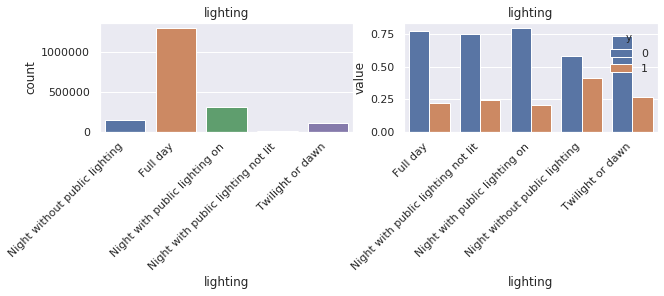

In [63]:
do_plot(col, df_cat2)

In [80]:
pd.get_dummies(df_cat2[[col]], drop_first=1)[['lighting_Night without public lighting']]

,lighting_Night without public lighting
0,1
1,1
2,1
3,1
4,1
...,...
1876000,0
1876001,0
1876002,0
1876003,0


In [81]:
x_train = pd.concat([pd.get_dummies(df_cat2[[col]], drop_first=1)[['lighting_Night without public lighting']], df_cat2[['y']]], axis = 1)
x_train.head()

,lighting_Night without public lighting,y
0,1,0
1,1,1
2,1,0
3,1,0
4,1,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(x_train, x_train.y, test_size=0.7, random_state=2018)
print(X_train.shape, X_test.shape)
mod = sm.GLM(y_train,X_train.drop(['y'], axis = 1),family = sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(X_test.drop(['y'], axis = 1))
print("Train AUC:", roc_auc_score(y_train, predsTrain), "Valid AUC:", roc_auc_score(y_test, preds))

(562801, 2) (1313204, 2)
Train AUC: 0.4613184224647733 Valid AUC: 0.4600667295772489


In [67]:
y_train = df_cat2[['y']]

mod = sm.GLM(y_train['y'],x_train,family = sm.families.Binomial())
res= mod.fit()
res.summary()
roc_auc_score(y_train.y, res.predict())

0.4825141691696177

### Categorical columns

In [7]:
df_cat = master_table[cols_to_model].select_dtypes('object')
df_cat.head()

,lighting,localization,intersection_type,weather,collision_type,road_category,road_regime,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,place_in_car,user_type,sex,equipment_used,pedestrian_action,pedestrian_alone
0,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,1,Driver,Male,yes,not specified or not applicable,NaN
1,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,1,Driver,Female,yes,not specified or not applicable,NaN
2,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,2,Passenger,Male,yes,not specified or not applicable,NaN
3,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,4,Passenger,Male,yes,not specified or not applicable,NaN
4,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,5,Passenger,Male,yes,not specified or not applicable,NaN


Replacing NA's - for now with 'NA'

In [8]:
si = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'NA', add_indicator=False)
temp = si.fit_transform(df_cat)
df_cat2 = pd.DataFrame(temp, columns = df_cat.columns)
df_cat2.head()

,lighting,localization,intersection_type,weather,collision_type,road_category,road_regime,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,place_in_car,user_type,sex,equipment_used,pedestrian_action,pedestrian_alone
0,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Male,yes,not specified or not applicable,NA
1,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Female,yes,not specified or not applicable,NA
2,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,2,Passenger,Male,yes,not specified or not applicable,NA
3,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,4,Passenger,Male,yes,not specified or not applicable,NA
4,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,5,Passenger,Male,yes,not specified or not applicable,NA


One hot encoding

In [9]:
df_cat3 = pd.get_dummies(df_cat2, drop_first = True)

In [10]:
df_cat3.columns = ['d_' + col for col in list(df_cat3.columns)]

In [11]:
df_cat_out = df_cat3.copy()

In [12]:
df_cat_out.head()

,d_lighting_Night with public lighting not lit,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Intersection in Y,d_intersection_type_Intersection with more than 4 branches,d_intersection_type_Level crossing,d_intersection_type_NA,d_intersection_type_Other intersection,d_intersection_type_Out of intersection,d_intersection_type_Place,d_weather_Dazzling weather,d_weather_Fog - smoke,d_weather_Heavy rain,d_weather_Light rain,d_weather_NA,d_weather_Normal,d_weather_Other,d_weather_Snow - hail,d_weather_Strong wind - storm,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_NA,d_road_category_National Road,d_road_category_Off public network,d_road_category_Parking lot open to public traffic,d_road_category_other,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_road_regime_With variable assignment channels,d_reserved_lane_Cycle Bank,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_Hill bottom,d_road_gradient_Hilltop,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,"d_road_plan_In ""S""",d_road_plan_NA,d_road_plan_Straight part,d_road_condition_fat - oil,d_road_condition_flooded,d_road_condition_icy,d_road_condition_mud,d_road_condition_normal,d_road_condition_other,d_road_condition_puddles,d_road_condition_snow,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_Exchanger or connection brace,d_infrastructure_NA,d_infrastructure_Pedestrian area,d_infrastructure_Railway,d_infrastructure_Toll zone,d_infrastructure_Underground - tunnel,d_accident_situation_On bike path,d_accident_situation_On emergency stop band,d_accident_situation_On the road,d_accident_situation_On the sidewalk,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_5,d_place_in_car_6,d_place_in_car_7,d_place_in_car_8,d_place_in_car_9,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_user_type_Pedestrian in rollerblade or scooter,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_Masked,d_pedestrian_action_Meaning bumping vehicle,d_pedestrian_action_NA,d_pedestrian_action_Opposite direction of the vehicle,d_pedestrian_action_Other,d_pedestrian_action_Playing - running,d_pedestrian_action_With animal,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_In a group,d_pedestrian_alone_NA,d_pedestrian_alone_Only
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0


In [13]:
df_cat_out.shape

(1876005, 100)

### Numeric columns 

In [14]:
cols_num = [
 'year',
 'month',
 'hour',
 'year_of_birth'
]

In [15]:
df_num = master_table[cols_num]
df_num.head()

,year,month,hour,year_of_birth
0,2005.0,1.0,19.0,1976.0
1,2005.0,1.0,19.0,1968.0
2,2005.0,1.0,19.0,1964.0
3,2005.0,1.0,19.0,2004.0
4,2005.0,1.0,19.0,1998.0


In [16]:
df_num.isna().mean()

year             0.016829
month            0.016829
hour             0.016829
year_of_birth    0.001253
dtype: float64

Imputing median

In [17]:
si = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=False)
temp = si.fit_transform(df_num)
df_num2 = pd.DataFrame(temp, columns = df_num.columns)
df_num2.head()

,year,month,hour,year_of_birth
0,2005.0,1.0,19.0,1976.0
1,2005.0,1.0,19.0,1968.0
2,2005.0,1.0,19.0,1964.0
3,2005.0,1.0,19.0,2004.0
4,2005.0,1.0,19.0,1998.0


Basic feature engineering - age at the time of accident

In [18]:
df_num2['user_age'] = df_num2['year'] - df_num2['year_of_birth']
df_num3 = df_num2.drop(['year_of_birth'], axis =1 )

In [19]:
df_num_out = df_num3.copy()

In [20]:
df_num_out.head()

,year,month,hour,user_age
0,2005.0,1.0,19.0,29.0
1,2005.0,1.0,19.0,37.0
2,2005.0,1.0,19.0,41.0
3,2005.0,1.0,19.0,1.0
4,2005.0,1.0,19.0,7.0


### Merging categorical and numeric columns

In [21]:
df_out = df_cat_out.join(df_num_out)

In [22]:
df_out['y'] = master_table.y

In [23]:
df_out.head()

,d_lighting_Night with public lighting not lit,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Intersection in Y,d_intersection_type_Intersection with more than 4 branches,d_intersection_type_Level crossing,d_intersection_type_NA,d_intersection_type_Other intersection,d_intersection_type_Out of intersection,d_intersection_type_Place,d_weather_Dazzling weather,d_weather_Fog - smoke,d_weather_Heavy rain,d_weather_Light rain,d_weather_NA,d_weather_Normal,d_weather_Other,d_weather_Snow - hail,d_weather_Strong wind - storm,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_NA,d_road_category_National Road,d_road_category_Off public network,d_road_category_Parking lot open to public traffic,d_road_category_other,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_road_regime_With variable assignment channels,d_reserved_lane_Cycle Bank,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_Hill bottom,d_road_gradient_Hilltop,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,"d_road_plan_In ""S""",d_road_plan_NA,d_road_plan_Straight part,d_road_condition_fat - oil,d_road_condition_flooded,d_road_condition_icy,d_road_condition_mud,d_road_condition_normal,d_road_condition_other,d_road_condition_puddles,d_road_condition_snow,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_Exchanger or connection brace,d_infrastructure_NA,d_infrastructure_Pedestrian area,d_infrastructure_Railway,d_infrastructure_Toll zone,d_infrastructure_Underground - tunnel,d_accident_situation_On bike path,d_accident_situation_On emergency stop band,d_accident_situation_On the road,d_accident_situation_On the sidewalk,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_5,d_place_in_car_6,d_place_in_car_7,d_place_in_car_8,d_place_in_car_9,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_user_type_Pedestrian in rollerblade or scooter,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_Masked,d_pedestrian_action_Meaning bumping vehicle,d_pedestrian_action_NA,d_pedestrian_action_Opposite direction of the vehicle,d_pedestrian_action_Other,d_pedestrian_action_Playing - running,d_pedestrian_action_With animal,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_In a group,d_pedestrian_alone_NA,d_pedestrian_alone_Only,year,month,hour,user_age,y
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,29.0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,37.0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,41.0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,1.0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,